# GBT  CoDR experiments

We implement some of the classes listed in V1.0 (Feb 2020) of the CoDR.   

* these are toy classes to show functionality
* not all member functions in all classes were implemented
* very minimal error checking
* an assumed organization of PS
 

This should eventually reproduce Example 1 (position switching) from the GBTIDL manual. The datafile **ngc5291.fits** you need is [here](http://safe.nrao.edu/wiki/pub/GB/Data/GBTIDLExampleAndSampleData/ngc5291.fits) or locally on **/n/chara/teuben/GBT**.  

## Example

We start off with a session as a GBT user might see this:

        ps = GBTLoadPS('a.fits')        # load the SDFITS file
        ps.summary()                    # overview times, sources, scans etc.
        ps.finalspectrum()              # calibrate and time/pol average
        ps.plot()                       # review the final plot 
        ps.save('a1.fits')              # save the spectrum (also SDFITS format)
        
This is an example of a well behave spectrum. No masking needed, no baseline fitting, just simple timeaveraging.

In [1]:
%matplotlib inline

from astropy.io import fits
from astropy import units as u
import numpy as np
import matplotlib
import copy
from matplotlib import pyplot as plt
from astropy.visualization import quantity_support
from specutils import Spectrum1D, SpectrumList

from astropy.io import ascii
from astropy.nddata import StdDevUncertainty
from astropy.table import Table
from astropy.units import Unit
from astropy.wcs import WCS
from astropy.convolution import convolve, Box1DKernel

from specutils.io import get_loaders_by_extension
from specutils.io.registers import data_loader
from specutils import Spectrum1D

# Spectrum

The class that contains one spectrum, something like Spectrum1D in specutils or Spectrum in pyspeckit. For now we are hardcoding the spectral axis in km/s, assuming the RESTFREQ is good.


In [2]:
pjt1 = False
#pjt1 = True

# pjt1=True should give the same results as False, but it's not working yet

In [3]:
class Spectrum(object):
    """
    contains a basic spectrum
    not used by users
    """
    def __init__(self, sp):
        if pjt1 and type(sp) == Spectrum:
            self.data  = np.copy(sp.data)
            self.meta  = sp.meta
            self.gbt   = copy.deepcopy(sp.gbt)
            self.xvals = sp.xvals
        else:   
            # assume this is a bintable
            self.data  = sp['DATA']
            self.meta  = sp
            self.gbt  = {}
            # construct a freq axis in GHz
            nchan = len(self.data)        
            crval1 = sp['CRVAL1']
            cdelt1 = sp['CDELT1']
            crpix1 = sp['CRPIX1']
            freq0  = sp['RESTFREQ']/1e9
            freq   = (crval1 + (np.arange(1,nchan+1) - crpix1) * cdelt1)/1e9
            c = 299792.458 # km/s
            vel = (1-freq/freq0)*c
            self.xvals = vel
            
    def __len__(self):
        return len(self.data)
        
        
    def stats(self, chans=None, label=""):
        """
        show Mean,RMS,Min,Max
        """
        if chans==None:
            c0 = 0
            c1 = len(self.data)
        else:
            c0 = chans[0]
            c1 = chans[1]
        mean = self.data[c0:c1].mean()
        rms  = self.data[c0:c1].std()
        dmin = self.data[c0:c1].min()
        dmax = self.data[c0:c1].max()
        ndat = c1-c0
        print("%s  %s %s %s %s %d" %  (label,repr(mean),repr(rms),repr(dmin),repr(dmax),ndat))
    
    def plot(self, xrange=None, yrange=None):
        """
        simple plot
        """
        if xrange != None:   plt.xlim(xrange[0], xrange[1])
        if yrange != None:   plt.ylim(yrange[0], yrange[1])
        plt.plot(self.xvals, self.data)
        plt.xlabel("Velocity (km/s)")
        plt.ylabel("Brightness (K)")
        plt.title("Source: %s" % self.meta['OBJECT'])

        
    def xy(self):
        """
        return spectrum
        """
        return (self.xvals, self.data)
             

# SDFITSLoad

This is the class that loads an SDFITS file. Normally not called by users, but by classes such as GBTLoadPS()



In [4]:
class SDFITSLoad(object):
    """
    container for a bintable from a selected HDU
    normally not used by users
    """
    def __init__(self, filename, hdu=1):
        """
        """
        print("==SDFITSLoad %s" % filename)
        self.filename = filename
        self.bintable = None
        self.hdu = fits.open(filename)
        self.header = self.hdu[0].header
        self.load(hdu)
    def load(self, hdu=1):
        """
        for given hdu make this bintable available
        """
        self.bintable = self.hdu[hdu]
        self.header2  = self.bintable.header
        self.data2    = self.bintable.data
        self.nchan    = len(self.data2[0]['DATA'])
        src = np.unique(self.data2[:]['OBJECT'])
        scan = np.unique(self.data2[:]['SCAN'])
        ncols = self.header2['NAXIS1']
        nrows = self.header2['NAXIS2']
        nflds = self.header2['TFIELDS']
        #
        print("File:     %s   HDU %d" % (self.filename, hdu))
        print("BINTABLE: %d rows x %d cols with %d chans" % (nrows,nflds,self.nchan))
        print("Sources: ",src)
        print("Scans:   ",scan)
    def __len__(self):
        return self.header2['NAXIS2']
        
        
s = SDFITSLoad('ngc5291.fits')

==SDFITSLoad ngc5291.fits
File:     ngc5291.fits   HDU 1
BINTABLE: 352 rows x 46 cols with 32768 chans
Sources:  ['NGC5291']
Scans:    [51 52 53 54 55 56 57 58]


# GBTLoad

This is the base class from which we derive all GBTLoad* subclasses that can load and calibrate spectra. It can also be used to load all the spectra, but there is no structure defined, e.g. to check and guide calibration.

In [5]:
class GBTLoad(object):
    def __init__(self, filename):
        """
        Holds a raw "unstructured" series of scans, normally not used by users
        """
        def ushow(name):
            uname = np.unique(self.s.data2[:][name])
            print('uniq',name,uname)
            return uname          
        print("==GBTLoad %s" % filename)
        self.filename = filename
        self.s = SDFITSLoad(filename)
        ushow('OBJECT')
        ushow('SCAN')
        ushow('SAMPLER')
        ushow('SIG')
        ushow('CAL')
        ushow('PROCSEQN')
        ushow('PROCSIZE')
        ushow('OBSMODE')               
        
        self.nrows = self.s.header2['NAXIS2']
        self.sp = np.empty(self.nrows, dtype=Spectrum)
        for i in range(self.nrows):
            self.sp[i] = Spectrum(self.s.data2[i])
            self.sp[i].gbt['row'] = i
            
    def __len__(self):
        return self.nrows
    def __getitem__(self, index):
        return self.sp[index]
    def __repr__(self):
        return self.filename
    def stats(self, chans=None):
        """
        show Mean,RMS,Min,Max
        """
        for i in range(self.nrows):
            self.sp[i].stats(chans,"%04d" % i)
    def debug(self, vars):
        """
        show some meta data variables
        """
        for i in range(self.nrows):
            out = ""
            for v in vars:
                out = out + repr(self.s.data2[i][v]) + " "
            print(out)

# PS example      
ex1 = GBTLoad('ngc5291.fits')

==GBTLoad ngc5291.fits
==SDFITSLoad ngc5291.fits
File:     ngc5291.fits   HDU 1
BINTABLE: 352 rows x 46 cols with 32768 chans
Sources:  ['NGC5291']
Scans:    [51 52 53 54 55 56 57 58]
uniq OBJECT ['NGC5291']
uniq SCAN [51 52 53 54 55 56 57 58]
uniq SAMPLER ['A13' 'A9']
uniq SIG ['T']
uniq CAL ['F' 'T']
uniq PROCSEQN [1 2]
uniq PROCSIZE [2]
uniq OBSMODE ['OnOff:PSWITCHOFF:TPWCAL' 'OnOff:PSWITCHON:TPWCAL']


In [6]:
#   FS example 
#ex2 = GBTLoad('W3OH.fits')

In [7]:
# NOD example 
#ex3 = GBTLoad('IC1481.fits')

In [8]:
# EDGE example 
#ex4 = GBTLoad('AGBT15B_287_35.raw.vegas.A.fits')

In [9]:
# ARGUS example
#ex5 = GBTLoad('AGBT17B_151_01.raw.vegas.A.fits')

In [10]:
#ex1.stats([3000,4000])
#ex1.debug(['DATE-OBS','CAL','SAMPLER','PROCSEQN'])

## Helper function

* **dcmeantsys**:   calibration routine
* **uniq**:         returns unique values in the order from the list (unlike np.unique)
* **sonoff**:       helper to find the On and Off scan numbers

In [11]:
def dcmeantsys(calon, caloff, tcal, mode=0, fedge=10, nedge=None):
    """
    following the GBTIDL routine with same name, get the tsys from 
    the neighboring calon and caloff we define an extra way to set 
    the edge size, nedge, if you prefer to use number of edge channels
    instead of the inverse fraction
    
    calon/caloff is meant to reflect the state of the noise diode
    
    mode=0     do the mean before the division
    mode=1     do the mean after the division
    """
    nchan = len(calon)
    if nedge == None:
        nedge = nchan // fedge     # 10 %
    if mode == 0:
        meanoff = np.mean(caloff[nedge:-nedge])
        meandiff = np.mean(calon[nedge:-nedge] - caloff[nedge:-nedge])
        meanTsys = ( meanoff / meandiff * tcal + tcal/2.0 )
    else:
        meanTsys = np.mean( caloff[nedge:-nedge] / (calon[nedge:-nedge] - caloff[nedge:-nedge]) )
        meanTsys = meanTsys * tcal + tcal/2.0
    return meanTsys

In [12]:
def uniq(seq):
    """ from http://stackoverflow.com/questions/480214/how-do-you-remove-duplicates-from-a-list-in-python-whilst-preserving-order """
    seen = set()
    seen_add = seen.add
    return [ x for x in seq if x not in seen and not seen_add(x)]


In [13]:
def sonoff(scan, procseqn):
    """
    return the list of On and Off scan numbers
    there must be a more elegant python way to do this....
    """
    sp = {}
    for (i,j) in zip(scan, procseqn):
        sp[i] = j
    
    us1 = uniq(scan)
    up1 = uniq(procseqn)
    
    sd = {}
    for i in up1:
        sd[i] = []
        
    for s in us1:
        sd[sp[s]].append(s)

    return sd

# PSScan

This class holds one PS scan, which consists of an "On" and "Off" scan.


The "Off" in particular can be constructed from other "Off"'s, or is a straight "Off" copy.

In [14]:
class PSScan(object):
    """
    Holds a PS scan - never used by users
    GBTLoadPS will hold one or more of such scans
    """
    #
    def __init__(self, sdfits, scan_on, scan_off):
        """
        """
        self.sdfits = sdfits
        self.status = 0
        #                           # ex1:
        self.nint = 0               # 11
        self.npol = 0               #  2
        self.on = None              # 44
        self.off = None             # 44
        self.calibrated = None      # 22
        self.timeaveraged = None    #  2
        self.polaveraged = None     #  1
        #
        self.nrows = len(scan_on)
        self.on = np.empty(self.nrows, dtype=Spectrum)
        self.off = np.empty(self.nrows, dtype=Spectrum)
        for (i,j,k) in zip(range(len(scan_on)),scan_on, scan_off):
            self.on[i] = Spectrum(sdfits.data2[j])
            self.off[i] = Spectrum(sdfits.data2[k])
            # remember the original row
            self.on[i].gbt['row'] = j
            self.off[i].gbt['row'] = k
        self.npol = 2
        self.nint = self.nrows // 4
    def debug(self):
        """
        no debug
        """
        print("WIP")
    def calibrate(self):
        """
        special PS calibration
        There are some arguments how *exactly* this is done
        """
        self.status = 1
        npolint = self.npol * self.nint
        self.calibrated = np.empty(npolint, dtype=Spectrum)
        for i in range(npolint):
            tcal = self.off[2*i].meta['TCAL']
            tsys = dcmeantsys(self.on[2*i].data,  self.on[2*i+1].data,tcal)
            #                 2*i is the CalON    2*i+1 the CalOFF
            #
            on = self.on[2*i].data
            off = self.off[2*i].data
            kr = self.on[2*i].gbt['row'] 
            if pjt1:
                self.calibrated[i] = Spectrum(self.on[2*i])
            else:
                self.calibrated[i] = Spectrum(self.sdfits.data2[kr])
            self.calibrated[i].data = tsys * (on-off) / off
            self.calibrated[i].gbt['row'] = kr
            self.calibrated[i].gbt['tsys'] = tsys
            # fix the meta data ; most of it is ok
    def timeaverage(self):
        """
        time averaging
        """
        self.status = 2
        self.timeaveraged = np.empty(self.npol, dtype=Spectrum)
        for i in range(self.npol):
            for j in range(self.nint):
                k = i*self.nint + j
                if j == 0:
                    data = self.calibrated[k].data
                else:
                    data = data + self.calibrated[k].data
            kr = self.calibrated[k].gbt['row']   
            self.timeaveraged[i] = Spectrum(self.sdfits.data2[kr])
            self.timeaveraged[i].data = data / self.nint
            self.timeaveraged[i].gbt['row'] = kr
            # fix the meta data; most of it is ok
    def polaverage(self):
        """
        polarization averaged ; needs to be stokes smart 
        """
        self.status = 3
        self.polaveraged = np.empty(1, dtype=Spectrum)
        for i in range(self.npol):
            if i==0:
                data = self.timeaveraged[i].data
            else:
                data = data + self.timeaveraged[i].data
        kr = self.timeaveraged[0].gbt['row']
        self.polaveraged[0] = Spectrum(self.sdfits.data2[kr])
        self.polaveraged[0].data = data / self.npol
        self.polaveraged[0].gbt['row'] = kr
        # fix the meta data
        
        

# ScanAvg

ScanAvg contains not only the polarization averages, but also the Stokes.

Another helper class that is normally never called by users.

In [15]:
class ScanAvg(object):
    """
    """
    def __init__(self):
        self.avg = None
        self.stokes = []
        

# GBTLoadPS

This is the class that loads and calibrates Position Switched (PS) data

In [16]:
class GBTLoadPS(GBTLoad):
    """
    
    """
    def __init__(self, filename):
        """
        Load SDFITS into a PS structure
        - should also allow SDFITSLoad() list
        - should also allow filename list
        - all assumed hdu=1
        """
        def ushow(name, show=False):
            uname = np.unique(self.sdfits.data2[:][name])
            if show: print('uniq',name,uname)
            return uname
                              
        self.filename = filename
        self.sdfits = SDFITSLoad(filename)
        self.scan = {}
        self.scanaveraged = None
        self.status = 0
        #
        d = self.sdfits.data2
        self.object = ushow('OBJECT')
        self.scans = ushow('SCAN')
        pols = ushow('SAMPLER')
        sigs = ushow('SIG')
        cals = ushow('CAL')
        proc = ushow('PROCSEQN')
        ushow('PROCSIZE')
        ushow('OBSMODE',True)
        dates = ushow('DATE-OBS')
        self.date0 = dates[0]
        self.date1 = dates[-1]
        # 
        sd = sonoff(self.sdfits.data2['SCAN'], self.sdfits.data2['PROCSEQN'])    
        print('OnOff scans:',sd)
        idx = np.arange(len(self.sdfits))
        for (i1,i2) in zip(sd[1],sd[2]):
            scan_on = idx[d['SCAN'] == i1]
            scan_off = idx[d['SCAN'] == i2]
            #print(i1,'on',scan_on[0],'...',scan_on[-1])
            #print(i2,'off',scan_off[0],'...',scan_off[-1])
            self.scan[i1] = PSScan(self.sdfits, scan_on, scan_off)
        
    def summary(self):
        print("GBTLoadPS %s" % self.filename)
        print("Sources:",self.object)
        print("Scans:",self.scans)
        print("Dates:",self.date0,self.date1)
    def stats(self, range=None):
        print('WIP')
    def calibrate(self):
        """
        calibrate each scan
        """
        self.status = 1 
        for scan in self.scan.keys():
            print("Calibrating",scan)
            self.scan[scan].calibrate()
            
    def timeaverage(self):
        """
        average in time for each scan
        """
        self.status = 2
        for scan in self.scan.keys():
            print("Timeaver",scan)
            self.scan[scan].timeaverage()
            
    def polaverage(self):
        """
        average polarizations for each scan
        """
        self.status = 3
        for scan in self.scan.keys():
            print("Polaver",scan)
            self.scan[scan].polaverage()
            
    def scanaverage(self):
        """
        averaging over scans
        """
        self.status = 4
        nscan = len(self.scan.keys())
        print("Scanaverage over %d scans" % nscan)
        self.scanaveraged = np.empty(1, dtype=Spectrum)
        for (i,scan) in zip(range(nscan),self.scan.keys()):
            kr = self.scan[scan].polaveraged[0].gbt['row']
            print('Scan %d Row %d' % (scan,kr))
            if i==0:
                data = self.scan[scan].polaveraged[0].data
            else:
                data = data + self.scan[scan].polaveraged[0].data
        self.scanaveraged[0] = Spectrum(self.sdfits.data2[kr])
        self.scanaveraged[0].data = data / nscan
        self.scanaveraged[0].gbt['row'] = kr    
        #
        if pjt1:
            sp0 = self.scan[scan].polaveraged[0]
            self.scanaveraged[0] = Spectrum(sp0)

p = GBTLoadPS('ngc5291.fits')

==SDFITSLoad ngc5291.fits
File:     ngc5291.fits   HDU 1
BINTABLE: 352 rows x 46 cols with 32768 chans
Sources:  ['NGC5291']
Scans:    [51 52 53 54 55 56 57 58]
uniq OBSMODE ['OnOff:PSWITCHOFF:TPWCAL' 'OnOff:PSWITCHON:TPWCAL']
OnOff scans: {1: [51, 53, 55, 57], 2: [52, 54, 56, 58]}


In [17]:
p.summary()

GBTLoadPS ngc5291.fits
Sources: ['NGC5291']
Scans: [51 52 53 54 55 56 57 58]
Dates: 2005-06-27T02:05:58.00 2005-06-27T02:28:23.93


In [18]:
p.calibrate()

Calibrating 51
Calibrating 53
Calibrating 55
Calibrating 57


In [19]:
p.timeaverage()

Timeaver 51
Timeaver 53
Timeaver 55
Timeaver 57


In [20]:
p.polaverage()

Polaver 51
Polaver 53
Polaver 55
Polaver 57


In [21]:
p.scanaverage()

Scanaverage over 4 scans
Scan 51 Row 20
Scan 53 Row 108
Scan 55 Row 196
Scan 57 Row 284


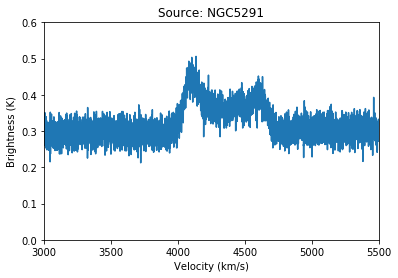

In [22]:
#xrange=[1.395,1.405]
xrange=[3000,5500]
yrange=[0.05,0.15]
#xrange=None
yrange=None
yrange=[0.0,0.6]
#

#yrange = np.array(yrange)
#xrange = np.array(xrange)
p.scanaveraged[0].plot(xrange=xrange, yrange=yrange)

This spectrum should have a baseline around 0.30 and the largest peak (on lowest velocity) about 0.50

# Plotting raw data

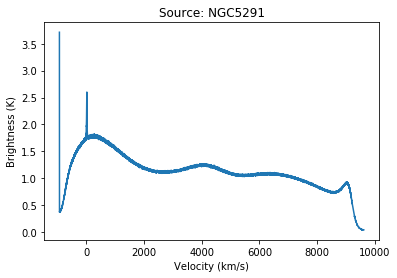

In [23]:
# p.plot(scan=51, int=0, pol=0, Raw=True)
sp0 = p.scan[51].on[0]
sp0.plot()

In [24]:
# p.plot(scan=51,int=0,pol=0, raw=True)
sp1 = p.scan[51].off[0]
(x0,y0) = sp0.xy()
(x1,y1) = sp1.xy()

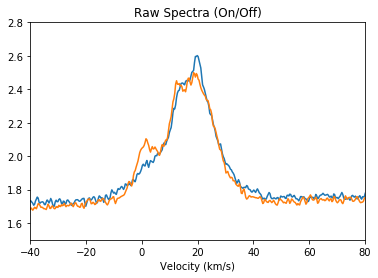

In [25]:
plt.plot(x0,y0)
plt.plot(x1,y1)
plt.xlim(-40,80)
plt.ylim(1.5,2.8)
plt.xlabel("Velocity (km/s)")
plt.title("Raw Spectra (On/Off)");

# Plotting some calibrated data 

This shows that integrations and polarizations are not easily accessable to the user. I just happen to know from the first 11 are XX and the second 11 are YY. This clearly should be classed up (or so)

        p.scan[51].calibrated['XX'][0]
        
it remains to be seen if the index should be 'XX', 'YY' (i.e. a dictionary), or 0,1 (in which case numpy.reshape can be effectively used.

22


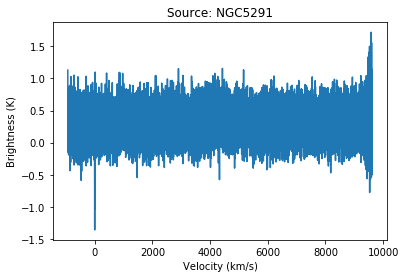

In [26]:
print(len(p.scan[51].calibrated))

# p.plot(scan=51, pol=0, int=0)
sp2 = p.scan[51].calibrated[0]
sp2.plot()

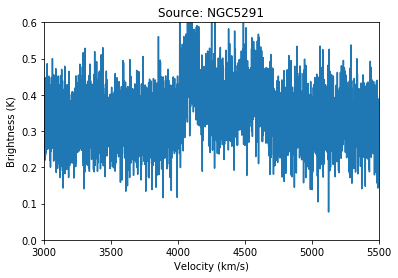

In [27]:
# p.plot(scan=51, pol=0)
sp3 = p.scan[51].timeaveraged[0]
sp3.plot(xrange=xrange, yrange=yrange)

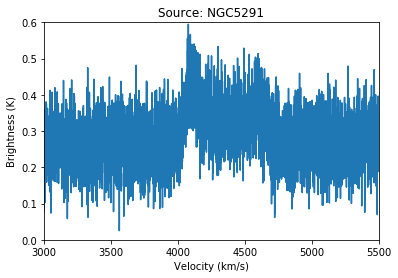

In [28]:
# p.plot(scan=51, pol=1)
sp4 = p.scan[51].timeaveraged[1]
sp4.plot(xrange=xrange, yrange=yrange)

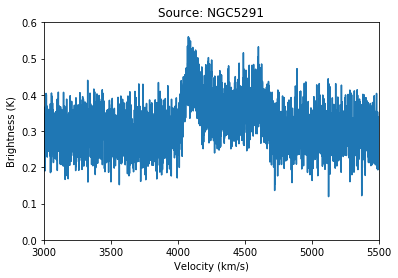

In [29]:
# one scan
# p.plot(scan=51)
sp5 = p.scan[51].polaveraged[0]
sp5.plot(xrange=xrange, yrange=yrange)

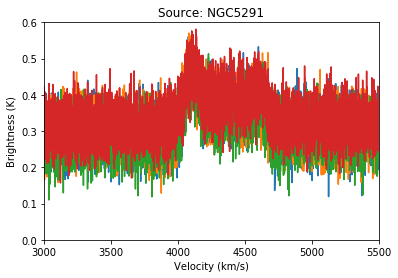

In [30]:
# all 4 scans
for s in p.scan.keys():
    sp6 = p.scan[s].polaveraged[0]
    sp6.plot(xrange=xrange, yrange=yrange)

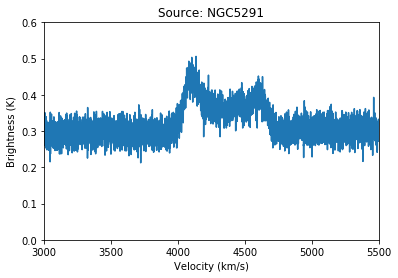

In [31]:
# final one again
# p.plot()
sp7 = p.scanaveraged[0]
sp7.plot(xrange=xrange, yrange=yrange)